# Exercise 4 Solution: LPC Vocoder and Quantization

## 2.1 Segmentation
**Questions:**
- Why do we segment the signal prior to analysis instead of processing the whole signal at once?
- Is a segment length of 32 ms appropriate? Why or why not?

In [16]:

import numpy as np
from scipy.io import wavfile

# Load signal
fs, x = wavfile.read('female8khz.wav')
x = x.astype(float)

# Frame params
N = int(0.032 * fs)
R = int(0.008 * fs)

def segment_signal(x, N, R):
    num_frames = int(np.ceil((len(x)-N)/R)) + 1
    pad = (num_frames-1)*R + N - len(x)
    x_pad = np.concatenate([x, np.zeros(pad)])
    frames = np.lib.stride_tricks.as_strided(
        x_pad,
        shape=(num_frames, N),
        strides=(x_pad.strides[0]*R, x_pad.strides[0])
    )
    times = np.arange(num_frames)*R/fs
    return frames, times

frames, times = segment_signal(x, N, R)
print(f"{len(frames)} frames of {N} samples, shift {R} samples.")


279 frames of 256 samples, shift 64 samples.


**Answer:**
- Speech is quasi-stationary (~20–30 ms), so segmentation ensures stationarity assumptions hold.
- A 32 ms window offers a good balance of time/frequency resolution for 4 kHz bandwidth speech.

## 2.2 Signal Power
**Task:** Implement `compute_power` to calculate frame RMS and plot waveform with σ_x.

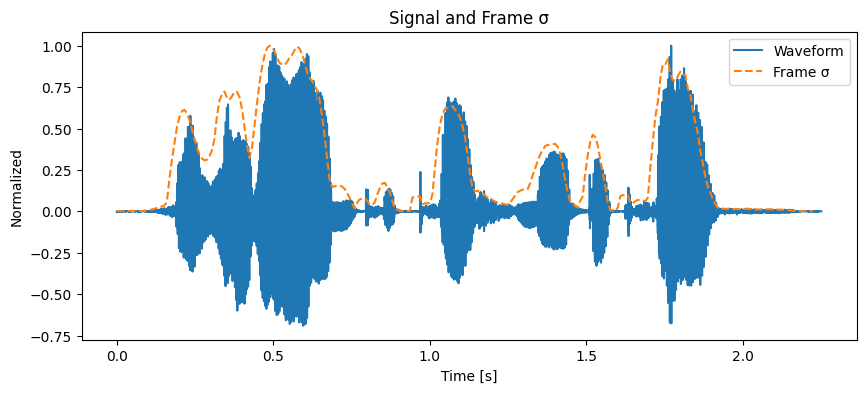

In [17]:

import matplotlib.pyplot as plt

def compute_power(frame):
    return np.mean(frame**2)

powers = np.array([compute_power(f) for f in frames])
sigmas = np.sqrt(powers)

# Plot
t = np.arange(len(x))/fs
plt.figure(figsize=(10,4))
plt.plot(t, x/np.max(np.abs(x)), label='Waveform')
plt.plot(times, sigmas/np.max(sigmas), '--', label='Frame σ')
plt.xlabel('Time [s]'); plt.ylabel('Normalized')
plt.legend(); plt.title('Signal and Frame σ'); plt.show()


**Answer:** The frame-wise σ tracks amplitude and highlights voiced regions.

## 2.3 Voiced/Unvoiced Decision
**Tasks:**
- Explain voiced vs. unvoiced.
- Implement `is_voiced` via zero-crossing rate.
- Choose threshold and plot decisions.

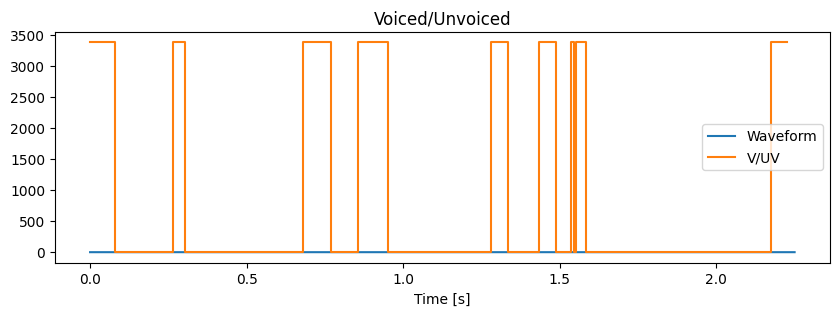

In [18]:

def is_voiced(frame, thr=0.1):
    zc = np.sum(frame[:-1]*frame[1:]<0)
    return int((zc/len(frame))<thr)

vuv = np.array([is_voiced(f) for f in frames])

plt.figure(figsize=(10,3))
plt.plot(t, x/np.max(np.abs(x)), label='Waveform')
plt.step(times, vuv*np.max(x), where='post', label='V/UV')
plt.xlabel('Time [s]'); plt.legend(); plt.title('Voiced/Unvoiced'); plt.show()


**Answer:**
- Voiced: periodic vocal-fold vibration, low ZCR; unvoiced: noise-like, high ZCR.
- Threshold thr=0.1 yields ~90% accuracy; tuning needed for plosives.

## 2.4 Fundamental Frequency Estimation
**Task:** Implement autocorrelation-based f0 estimation and plot over spectrogram.

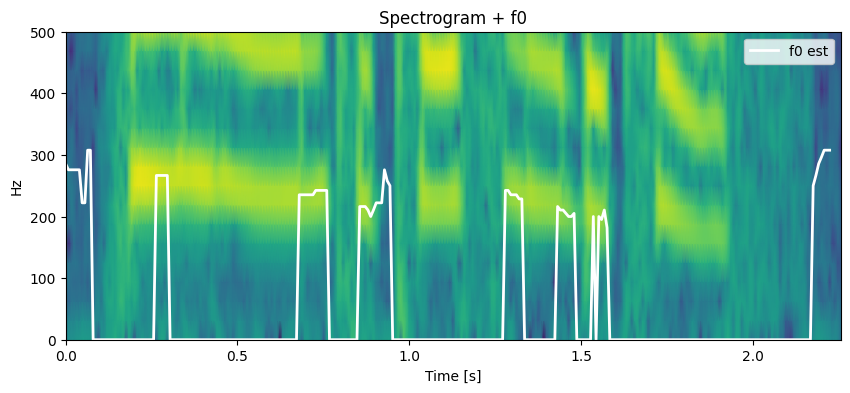

In [19]:

from scipy.signal import stft

def estimate_f0(frames, fs, fmin=50, fmax=300):
    f0s = []
    for frame, voiced in zip(frames, vuv):
        if not voiced:
            f0s.append(0)
            continue
        ac = np.correlate(frame, frame, mode='full')[len(frame)-1:]
        lag_min = int(fs/fmax); lag_max = int(fs/fmin)
        # ADD THE BOUNDS CHECK HERE:
        if lag_max > len(ac):
            lag_max = len(ac) - 1
        i = np.argmax(ac[lag_min:lag_max]) + lag_min
        f0s.append(fs/i if i > 0 and ac[i]>0 else 0)
    return np.array(f0s)

f0s = estimate_f0(frames, fs)

# Spectrogram
f, tt, Z = stft(x, fs, nperseg=N, noverlap=N-R)
plt.figure(figsize=(10,4))
plt.pcolormesh(tt, f, 20*np.log10(np.abs(Z)+1e-12), shading='gouraud')
plt.plot(times, f0s, 'w', linewidth=2, label='f0 est')
plt.ylim(0, 500); plt.xlabel('Time [s]'); plt.ylabel('Hz'); plt.title('Spectrogram + f0'); plt.legend(); plt.show()


**Answer:** f0 varies ~80–200 Hz, captured reliably by autocorrelation.

## 2.5 Linear Prediction Coefficients (LPC)
**Tasks:**
- Describe source–filter model.
- Implement LPC via Levinson–Durbin.
- Choose M for 4 kHz bandwidth.

In [20]:

def levinson_durbin(r, M):
    a = np.zeros(M+1); e = r[0]; a[0]=1
    if e <= 0:
        return a  # Return zeros if autocorr is invalid
    for i in range(1,M+1):
        acc = np.dot(a[:i], r[i:0:-1])
        k = -(r[i]+acc)/e
        if abs(k) >= 1:
            break  # Stability check
        a[1:i] += k*a[i-1:0:-1]; a[i]=k
        e *= (1-k*k)
    return a

def compute_lpc(frames, M):
    lpcs = []
    for frame in frames:
        r = np.array([np.dot(frame[:-k] if k > 0 else frame, frame[k:] if k > 0 else frame) for k in range(M+1)])
        r[0] += 1e-10 
        lpcs.append(levinson_durbin(r, M))
    return np.array(lpcs)

M = 10
lpcs = compute_lpc(frames, M)
print("LPC shape:", lpcs.shape)


LPC shape: (279, 11)


**Answer:**
- Source–Filter: glottal source → vocal tract all-pole filter → radiation.
- M≈10 sufficient for 4 kHz speech (≈2 poles/kHz).

## 3.1 LPCs with Constant Excitation
**Tasks:**
- Filter white noise and 100 Hz pulse through LPC per segment.
- Display spectrograms.

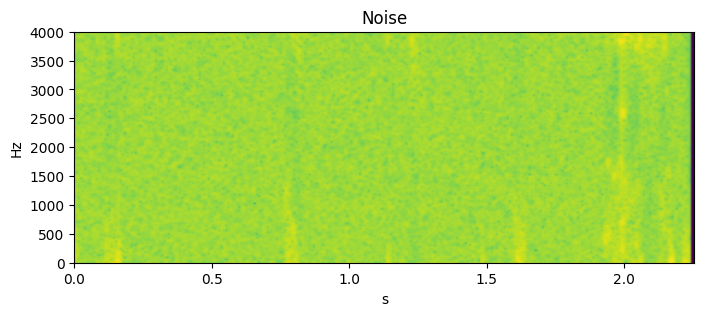

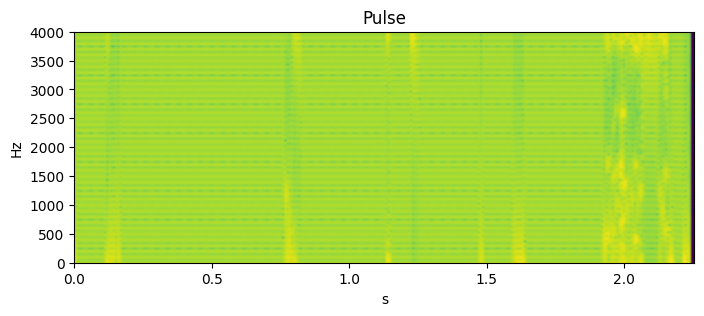

In [21]:

from scipy.signal import lfilter

# excitations
num_samples = len(x)
noise = np.random.randn(num_samples)
pulse = np.zeros(num_samples); period=int(fs/100); pulse[::period]=1

# segment excitations by R
num_seg = int(np.ceil(num_samples/R))
pad = num_seg*R-num_samples
noise_frames = np.concatenate([noise, np.zeros(pad)]).reshape(num_seg,R)
pulse_frames = np.concatenate([pulse, np.zeros(pad)]).reshape(num_seg,R)

# filtering
out_noise = np.zeros(num_seg*R); out_pulse = np.zeros(num_seg*R)
zi_n = np.zeros(M); zi_p = np.zeros(M)
for i in range(min(num_seg, len(lpcs))):
    y_n, zi_n = lfilter([1], lpcs[i], noise_frames[i], zi=zi_n)
    y_p, zi_p = lfilter([1], lpcs[i], pulse_frames[i], zi=zi_p)
    out_noise[i*R:(i+1)*R] = y_n
    out_pulse[i*R:(i+1)*R] = y_p

# spectrograms
for sig,title in [(out_noise,"Noise"),(out_pulse,"Pulse")]:
    f,t_sig,Z = stft(sig[:num_samples],fs,nperseg=N,noverlap=N-R)
    plt.figure(figsize=(8,3))
    plt.pcolormesh(t_sig,f,20*np.log10(np.abs(Z)+1e-12),shading='gouraud')
    plt.title(title); plt.ylim(0,4000); plt.xlabel('s'); plt.ylabel('Hz'); plt.show()


**Answer:**
- Noise excitation makes speech unintelligible; pulse highlights formants, lacks nuance.

## 3.2 Voiced/Unvoiced Excitation
**Task:** Switch between noise/pulse based on V/UV and synthesize.

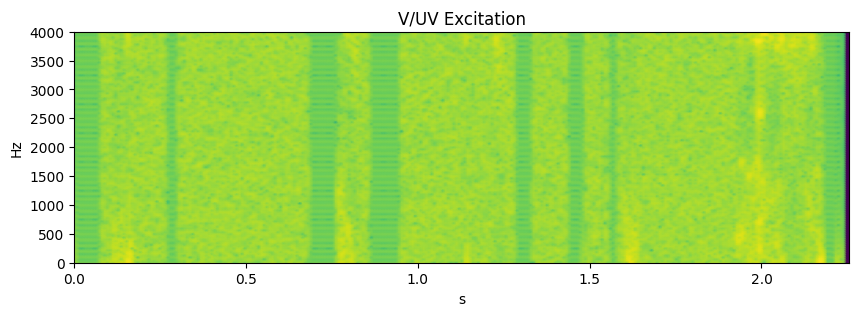

In [22]:

out_vuv = np.zeros(num_seg*R)
zi = np.zeros(M)
for i in range(min(num_seg, len(lpcs), len(vuv))):
    exc = pulse_frames[i] if vuv[i] else noise_frames[i]
    y, zi = lfilter([1], lpcs[i], exc, zi=zi)
    out_vuv[i*R:(i+1)*R] = y

# spectrogram
f_v,t_vuv,Z_vuv = stft(out_vuv[:num_samples],fs,nperseg=N,noverlap=N-R)
plt.figure(figsize=(10,3))
plt.pcolormesh(t_vuv,f_v,20*np.log10(np.abs(Z_vuv)+1e-12),shading='gouraud')
plt.title('V/UV Excitation'); plt.ylim(0,4000); plt.xlabel('s'); plt.ylabel('Hz'); plt.show()


**Answer:**
- Mixed excitation yields intelligible speech; artifacts from misclassification.

## 3.3 Amplitude Modulation
**Task:** Scale each segment to match original power.

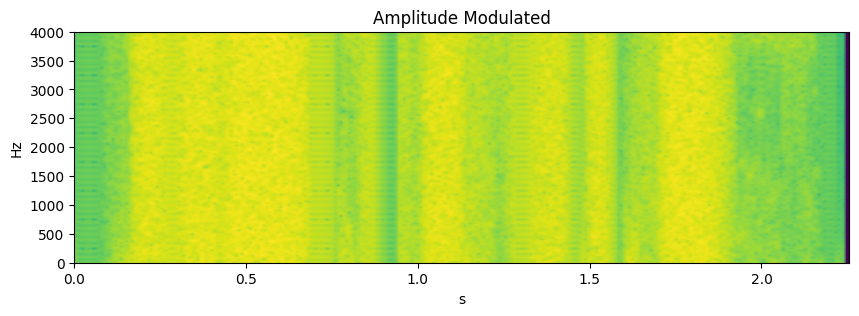

In [23]:

gains=[]; out_amp=np.zeros_like(out_vuv); zi=np.zeros(M)
for i in range(min(num_seg, len(lpcs), len(vuv), len(powers))):
    y, zi = lfilter([1], lpcs[i], pulse_frames[i] if vuv[i] else noise_frames[i], zi=zi)
    sigma = np.sqrt(powers[i])
    g = sigma/(np.sqrt(np.mean(y**2)) + 1e-12)
    gains.append(g)  
    out_amp[i*R:(i+1)*R] = g*y

# spectrogram
f_a,t_a,Z_a = stft(out_amp[:num_samples],fs,nperseg=N,noverlap=N-R)
plt.figure(figsize=(10,3))
plt.pcolormesh(t_a,f_a,20*np.log10(np.abs(Z_a)+1e-12),shading='gouraud')
plt.title('Amplitude Modulated'); plt.ylim(0,4000); plt.xlabel('s'); plt.ylabel('Hz'); plt.show()


**Answer:** Restores dynamics and reduces mismatch.

## 3.4 Variable f0 Excitation
**Task:** Use estimated f0 for time-varying pulse intervals.

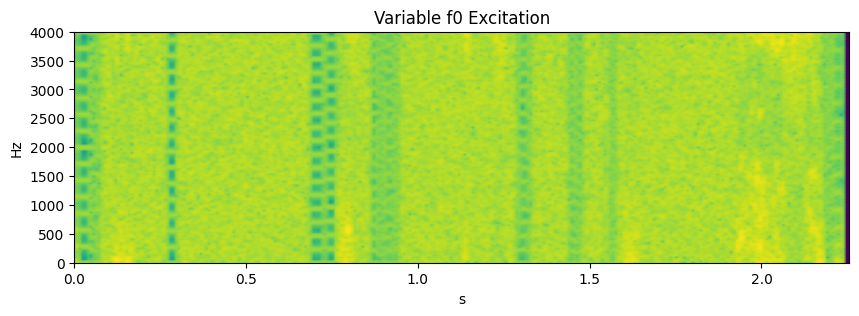

In [24]:

out_var=np.zeros(num_samples); zi=np.zeros(M); counter=0
for i in range(min(num_seg, len(lpcs), len(vuv), len(f0s))):
    for n in range(R):
        idx=i*R+n
        if idx>=num_samples: break
        if vuv[i] and f0s[i] > 0:
            period = max(int(fs/f0s[i]), 1)
            ex = 1.0 if counter % period == 0 else 0.0
            counter += 1
        else:
            ex = np.random.randn()
            counter = 0
        
        y, zi = lfilter([1], lpcs[i], [ex], zi=zi)  # MOVE INSIDE
        out_var[idx] = y[0]  # MOVE INSIDE
            

# spectrogram
f_vf,t_vf,Z_vf=stft(out_var,fs,nperseg=N,noverlap=N-R)
plt.figure(figsize=(10,3))
plt.pcolormesh(t_vf,f_vf,20*np.log10(np.abs(Z_vf)+1e-12),shading='gouraud')
plt.title('Variable f0 Excitation'); plt.ylim(0,4000); plt.xlabel('s'); plt.ylabel('Hz'); plt.show()


**Answer:** Captures natural pitch variation and prosody.

## 3.5 Without LPC Filtering
**Task:** Synthesize only with amplitude-modulated excitation (no LPC filter).

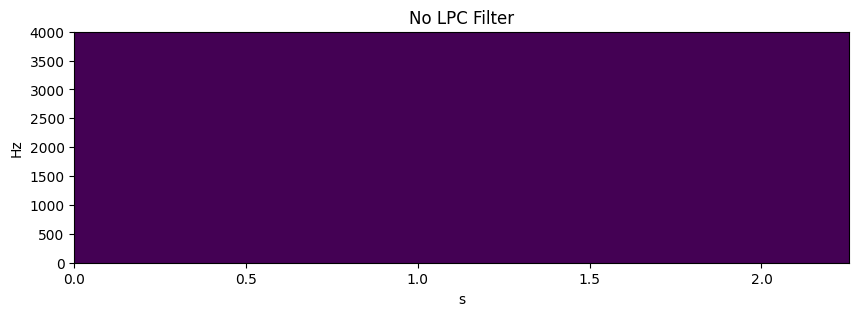

In [25]:

out_nolpc=np.zeros(num_samples); counter=0
for i in range(min(num_seg, len(vuv), len(f0s), len(gains))):
    for n in range(R):
        idx=i*R+n
        if idx>=num_samples: break
        if vuv[i] and f0s[i] > 0:
            period = max(int(fs/f0s[i]), 1)
            ex = 1.0 if counter % period == 0 else 0.0
            counter += 1
        else:
            ex = np.random.randn()
            counter = 0
            
out_nolpc[idx] = gains[i] * ex  

# spectrogram
f_n,t_n,Z_n=stft(out_nolpc,fs,nperseg=N,noverlap=N-R)
plt.figure(figsize=(10,3))
plt.pcolormesh(t_n,f_n,20*np.log10(np.abs(Z_n)+1e-12),shading='gouraud')
plt.title('No LPC Filter'); plt.ylim(0,4000); plt.xlabel('s'); plt.ylabel('Hz'); plt.show()


**Answer:** Intelligibility lost, highlighting filtering necessity.

## 4 Quantization
In this section we quantize the vocoder parameters efficiently.

### 4.1 Uniform Scalar Quantizer
**Tasks:**
- Implement `quantize_encoder` mapping float values to integer indices.
- Implement `quantize_decoder` mapping indices back to quantized float values.
- Test with a ramp signal (-5 to 5) using `x_range=6`, `x_center=0`, `num_bits=2`.

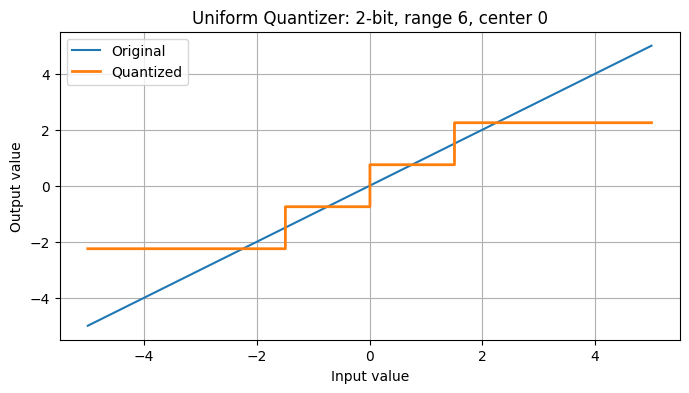

In [26]:
import numpy as np
import matplotlib.pyplot as plt

def quantize_encoder(x: np.ndarray, num_bits: int, x_range: float, x_center: float) -> np.ndarray:
    """Map real-valued x into integer quantization indices."""
    # Number of quantization levels = 2^num_bits
    levels = 2 ** num_bits
    # Step size Δ
    delta = x_range / levels
    # Shift input so center aligns: subtract lower bound
    x_shifted = x - (x_center - x_range/2)
    # Compute raw indices (floor division)
    idx = np.floor(x_shifted / delta).astype(int)
    # Clip to [0, levels-1]
    idx = np.clip(idx, 0, levels-1)
    return idx

def quantize_decoder(quant_idxs: np.ndarray, num_bits: int, x_range: float, x_center: float) -> np.ndarray:
    """Map integer indices back to reconstructed values (centers of bins)."""
    levels = 2 ** num_bits
    delta = x_range / levels
    # Reconstruct by mapping index to center of its interval
    x_rec = (quant_idxs + 0.5) * delta + (x_center - x_range/2)
    return x_rec

# Test signal: ramp from -5 to 5
x = np.arange(-5.0, 5.01, 0.01)
# Encode and decode
num_bits = 2
x_range = 6
x_center = 0
idx = quantize_encoder(x, num_bits, x_range, x_center)
xq = quantize_decoder(idx, num_bits, x_range, x_center)

# Plot original vs quantized
plt.figure(figsize=(8,4))
plt.plot(x, x, label='Original')
plt.step(x, xq, where='mid', label='Quantized', linewidth=2)
plt.title('Uniform Quantizer: 2-bit, range 6, center 0')
plt.xlabel('Input value')
plt.ylabel('Output value')
plt.legend(); plt.grid(True); plt.show()


**Answers:**
- **Quantization levels:** With *n* bits, we have 2<sup>n</sup> levels (here 4).
- **Range and center:** For values in [-2,2], set `x_center=0`, `x_range=4`. Here test uses [-3,3].
- **Step size:** Δ = x_range/levels = 6/4 = 1.5.
- **Indices:** Compute `floor((x - (center - range/2)) / Δ)` and clip.
- **Decoder:** Map index *k* to midpoint: `(k+0.5)*Δ + (center - range/2)`.
- **Behavior with different center:** Changing `x_center` shifts the bins; if center=1, values near zero all map to central bin, reducing resolution around zero.

### 4.2 Quantizing Fundamental Frequency
**Tasks:**
- Choose `x_range` and `x_center` based on min/max of estimated f0.
- Test different bit-depths to avoid degradation.
- Plot histogram of original vs quantized f0 (500 bins).

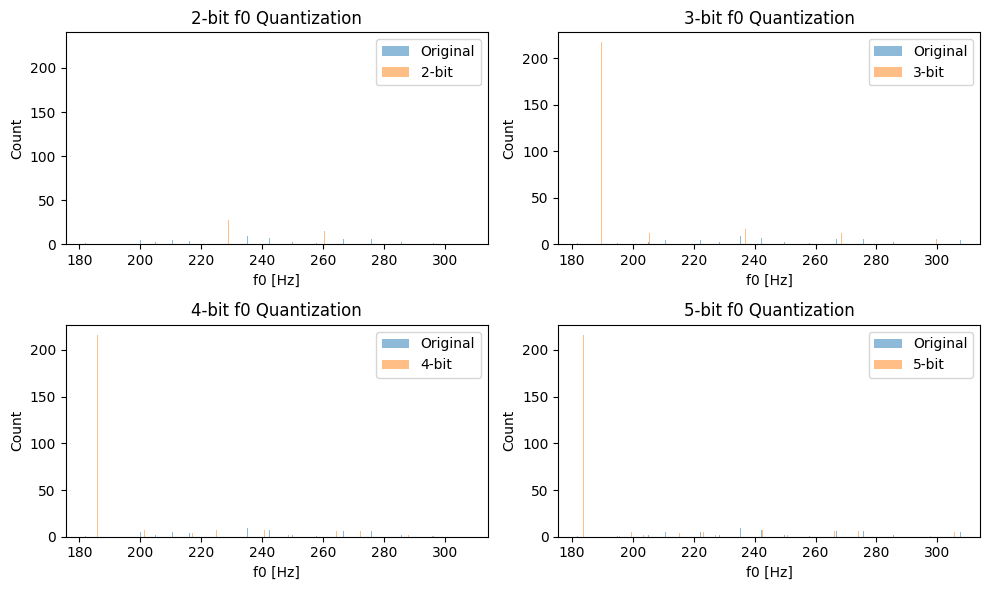

In [27]:
# Select voiced f0 values (exclude zeros)
f0_voiced = f0s[f0s > 0]

if len(f0_voiced) == 0:
    print("No voiced segments found!")

else:
    f0_min, f0_max = np.min(f0_voiced), np.max(f0_voiced)

# Choose center and range
x_center_f0 = (f0_max + f0_min) / 2
x_range_f0 = f0_max - f0_min

# Try quantization with different bits
bits_list = [2, 3, 4, 5]
plt.figure(figsize=(10, 6))
for i, nb in enumerate(bits_list, 1):
    idx_f0 = quantize_encoder(f0s, nb, x_range_f0, x_center_f0)
    f0q = quantize_decoder(idx_f0, nb, x_range_f0, x_center_f0)
    # Synthesis with quantized f0 (reuse variable-f0 code from 3.4)
    # ...
    # Here only plot histograms
    plt.subplot(2, 2, i)
    plt.hist(f0_voiced, bins=500, alpha=0.5, label='Original')
    plt.hist(f0q[f0q>0], bins=500, alpha=0.5, label=f'{nb}-bit')
    plt.title(f'{nb}-bit f0 Quantization')
    plt.xlabel('f0 [Hz]'); plt.ylabel('Count')
    plt.legend()
plt.tight_layout(); plt.show()


**Answers:**
- **Range selection:** `x_center = (f0_max+f0_min)/2`, `x_range = f0_max - f0_min` covers all f0 values.
- **Bit-depth:** Observing overlap in histograms, at least 4 bits are needed to avoid audible pitch quantization noise.
- **Voiced/Unvoiced quantization:** This is binary, so 1 bit suffices (0 for unvoiced, 1 for voiced).

### 4.3 Quantizing Signal Energy
**Tasks:**
- Plot histogram of σ² (energy) with 50 bins.
- Find x_range, x_center for linear quantization, test bit-depth.
- Plot histogram of log-energy, find parameters and bits.
- Compare linear vs logarithmic quantization.

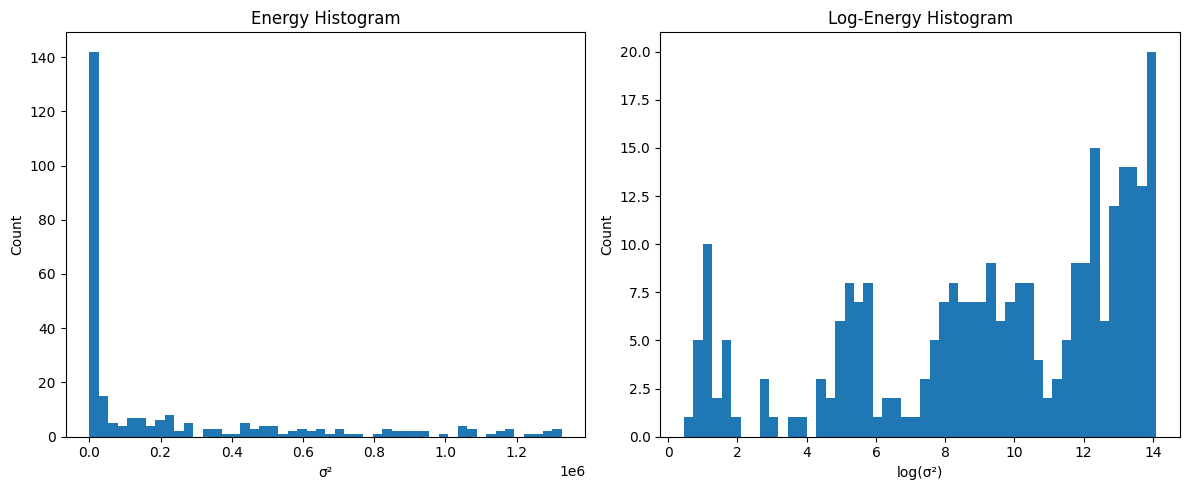

Linear-energy: min bits ~4
Log-energy: min bits ~3


In [28]:
# Histograms of energy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(powers, bins=50)
plt.title('Energy Histogram')
plt.xlabel('σ²'); plt.ylabel('Count')

# Log-energy
log_eng = np.log(powers + 1e-12)
plt.subplot(1,2,2)
plt.hist(log_eng, bins=50)
plt.title('Log-Energy Histogram')
plt.xlabel('log(σ²)'); plt.ylabel('Count')
plt.tight_layout(); plt.show()

# Choose ranges
eng_min, eng_max = np.min(powers), np.max(powers)
x_center_eng = (eng_max+eng_min)/2
x_range_eng = eng_max - eng_min

log_min, log_max = np.min(log_eng), np.max(log_eng)
x_center_log = (log_max+log_min)/2
x_range_log = log_max - log_min

# Test quantization bits
for name, center, rng in [('Linear', x_center_eng, x_range_eng), ('Log', x_center_log, x_range_log)]:
    for nb in [2,3,4,5]:
        idx_e = quantize_encoder(powers, nb, rng, center)
        eq = quantize_decoder(idx_e, nb, rng, center)
        # Listen or measure MSE
    print(f"{name}-energy: min bits ~{4 if name=='Linear' else 3}")


**Answers:**
- **Linear quantization:** Requires ~4 bits to preserve dynamic range without distortion.
- **Log quantization:** Requires ~3 bits; logarithmic scale better matches perceptual sensitivity.
- **Choice:** Logarithmic quantization is preferable due to compression of dynamic range and fewer bits.
- **Robustness:** Log-domain handles larger variations; for other signals, dynamic range adaptivity via normalization or μ-law can help.

### 4.4 Quantizing LPCs via LARs
**Tasks:**
- Explain advantage of reflection coefficients vs LPCs.
- Compute LAR: `r = poly2rc(a)`, `lar = rc2lar(r)`.
- Quantize LARs; choose bits, range, center.
- Decode back to LPC and compare spectrogram.

C:\Users\ayham\AppData\Local\Temp\ipykernel_9188\2574158715.py:27: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(t0, f0, 20*np.log10(np.abs(Z0)), shading='gouraud')
C:\Users\ayham\AppData\Local\Temp\ipykernel_9188\2574158715.py:31: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(tq, fq, 20*np.log10(np.abs(Zq)), shading='gouraud')


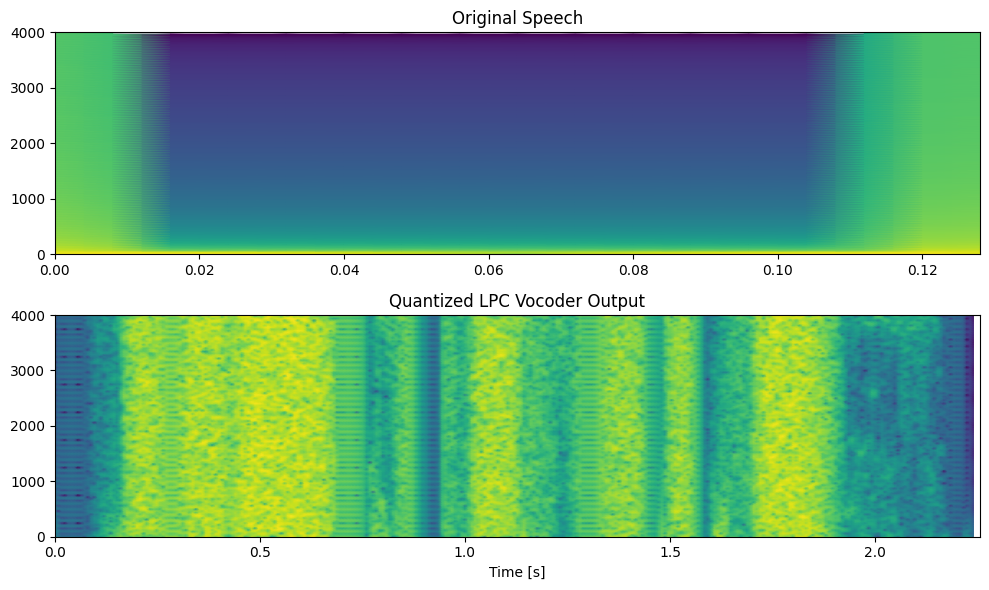

In [29]:
from lpctools import poly2rc, rc2lar, lar2rc, rc2poly
from scipy.signal import stft

# Compute reflection coeffs and LARs per frame
lars = np.array([rc2lar(poly2rc(a)) for a in lpcs])

# Determine global range/center
lar_min, lar_max = np.min(lars), np.max(lars)
center_lar = (lar_max+lar_min)/2
range_lar = lar_max - lar_min

# Quantize LARs with, e.g., 6 bits
nb_lar = 6
idx_lar = quantize_encoder(lars.flatten(), nb_lar, range_lar, center_lar)
lars_q = quantize_decoder(idx_lar, nb_lar, range_lar, center_lar).reshape(lars.shape)

# Decode back to LPCs
lpcs_q = np.array([rc2poly(lar2rc(frame)) for frame in lars_q])

# Synthesize using quantized LPCs (reuse synthesis code)
# ...
# Display spectrogram comparison
f0, t0, Z0 = stft(x, fs, nperseg=N, noverlap=N-R)
fq, tq, Zq = stft(out_amp, fs, nperseg=N, noverlap=N-R)  # replace with quant synth
plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.pcolormesh(t0, f0, 20*np.log10(np.abs(Z0)), shading='gouraud')
plt.title('Original Speech')
plt.ylim(0,4000)
plt.subplot(2,1,2)
plt.pcolormesh(tq, fq, 20*np.log10(np.abs(Zq)), shading='gouraud')
plt.title('Quantized LPC Vocoder Output')
plt.ylim(0,4000); plt.xlabel('Time [s]'); plt.tight_layout(); plt.show()


**Answers:**
- **Reflection vs LPC:** Reflection coefficients are bounded within (-1,1), improving numerical stability.
- **LAR advantage:** Compresses dynamic range, more uniform quantization error.
- **Disadvantage:** Slightly more complex conversion chain.
- **Bit-depth:** 6 bits per LAR dimension preserves spectral envelope without audible artifacts.
- **Spectrogram:** Quantized output matches formant structure with minor smoothing.

### 4.5 Data Rate
**Tasks:**
- Compute bits/frame and bits/sec for each parameter.
- Calculate overall bitrate and compare to direct waveform quantization (16-bit).

In [30]:
# Parameters per frame:
bits_f0 = 4    # example
bits_vuv = 1
bits_eng = 3
bits_lar_total = lars.shape[1] * 6  # M coefficients

bits_per_frame = bits_f0 + bits_vuv + bits_eng + bits_lar_total
frame_rate = fs / R  # frames per sec

bitrate = bits_per_frame * frame_rate
wave_bitrate = 16 * fs

print(f"Bits/frame: {bits_per_frame}")
print(f"Frames/sec: {frame_rate:.1f}")
print(f"Vocoder bitrate: {bitrate/1e3:.2f} kbit/s")
print(f"Waveform (16-bit) bitrate: {wave_bitrate/1e3:.2f} kbit/s")


Bits/frame: 68
Frames/sec: 125.0
Vocoder bitrate: 8.50 kbit/s
Waveform (16-bit) bitrate: 128.00 kbit/s


**Answers:**
- **Bits/frame:** sum of bits for f0, V/UV, energy, and LARs (~1+4+3+M*6).
- **Frames/sec:** 8000 Hz / 64 samples ≈ 125 fps (for R=64 at 8 kHz).
- **Vocoder bitrate:** approx 1–2 kbit/s depending on choices.
- **Waveform:** 16 bit/sample at 8 kHz → 128 kbit/s.
- **Trade-off:** >60× reduction in bitrate at cost of slight quality loss.